In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData, UVCal, UVFlag, utils
from glob import glob
from astropy import units as u
from astropy import constants as c
from astropy.time import Time
from astropy.coordinates import get_body, SkyCoord, AltAz, EarthLocation, Angle
from copy import deepcopy
import os

In [33]:
jds = [str(jd) for jd in np.arange(2457548, 2457555)]
lstpath = '/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/LSTSlice/'

In [3]:
lstfiles = {}
for jd in jds:
    lstfiles[jd] = np.sort(glob(lstpath+jd+'/lst*.uvh5'))
    print(len(lstfiles[jd]))

116
116
116
116
116
116
116


In [4]:
for jd in jds:
    print(jd, lstfiles[jd][0].split('/')[-1].split('.')[2], lstfiles[jd][-1].split('/')[-1].split('.')[2])

2457548 11h00m00s 22h30m00s
2457549 11h00m00s 22h30m00s
2457550 11h00m00s 22h30m00s
2457551 11h00m00s 22h30m00s
2457552 11h00m00s 22h30m00s
2457553 11h00m00s 22h30m00s
2457554 11h00m00s 22h30m00s


In [70]:
nfiles = len(lstfiles[jds[0]])
print(nfiles)

116


In [19]:
bl_typ = (9,10,'xx')

In [6]:
for ifile in np.arange(80,81):#nfiles):
    uvfs = {}
    uvds = {}
    uvdbl = {}
    for ijd, jd in enumerate(jds):
        uvd = UVData()
        uvd.read(lstfiles[jd][ifile])
        uvds[jd] = uvd
        uvdbl[jd] = uvd.get_data(bl_typ)
        #dirname, filename = os.path.split(lstfile)
        #basename, ext = os.path.splitext(filename)
        uvf = UVFlag(uvd, mode='flag', copy_flags=True, run_check=True)
        uvf.to_waterfall(method='and', keep_pol=False)
        uvfs[jd] = uvf
        #flagname = basename+'.flh5'
        #print(flagname)
        #uvf.write(os.path.join(dirname,flagname),clobber=True)

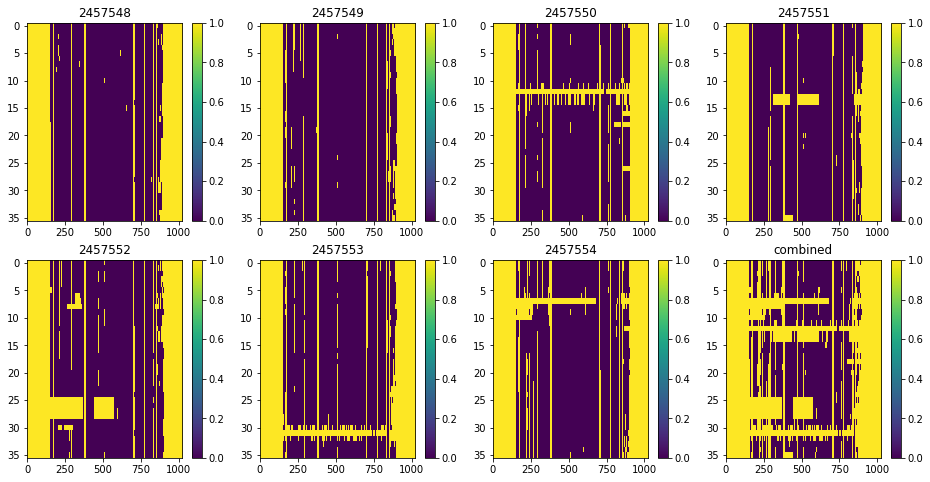

In [7]:
plt.figure(figsize=(16,8))
combined = uvfs[jds[0]].flag_array
for i in np.arange(7):
    plt.subplot(2,4,i+1)               
    fl = uvfs[jds[i]].flag_array
    combined = np.logical_or(combined, fl)
    plt.imshow(np.array(fl.squeeze(),dtype='float64'), aspect='auto')
    plt.colorbar()
    plt.title(jds[i])
plt.subplot(248)
plt.title('combined')
plt.imshow(np.array(combined.squeeze(),dtype='float64'), aspect='auto')
plt.colorbar()

In [8]:
for i in np.arange(7):
    fl = uvfs[jds[i]].flag_array[:,150:900,0]
    print(fl.sum()/fl.size)
print(combined[:,150:900,0].sum()/combined[:,150:900,0].size)

0.09722222222222222
0.08992592592592592
0.13277777777777777
0.11033333333333334
0.13966666666666666
0.15003703703703702
0.13318518518518518
0.37033333333333335


divide by zero encountered in log10
divide by zero encountered in true_divide


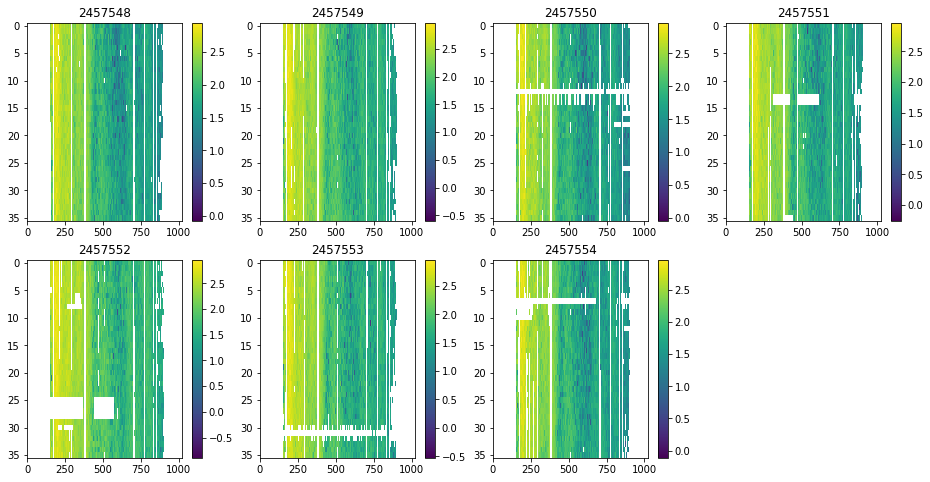

In [9]:
plt.figure(figsize=(16,8))
for i in np.arange(7):
    plt.subplot(2,4,i+1)               
    bl = uvdbl[jds[i]].squeeze()
    
    plt.imshow(np.log10(np.abs(bl))/~uvfs[jds[i]].flag_array.squeeze(), aspect='auto')
    #plt.imshow(np.log10(np.abs(bl)), aspect='auto', vmin=0, vmax=2.5)
    #plt.imshow(np.angle(bl), aspect='auto', cmap='twilight')
    plt.colorbar()
    plt.title(jds[i])

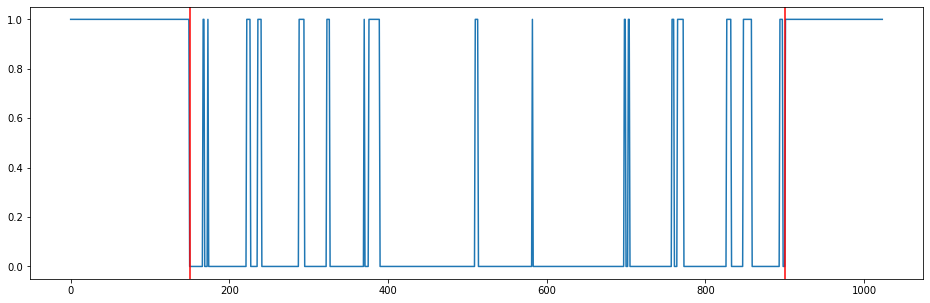

In [11]:
plt.figure(figsize=(16,5))
plt.plot(uvfs[jds[i]].flag_array[0,:])
plt.axvline(150,color='red')
plt.axvline(900,color='red')

In [49]:
# For every JD, create an average of the *other* JDs
uvds_avg = {}
# And a new UVData with the homogenized flags between the average and the given day
uvds_hflag = {}
for jd in jds:
    jds_butone = jds.copy()
    jds_butone.remove(jd)
    print(jd)
    print(jds_butone)
    Njds = len(jds_butone)
    # Everything is the same size, so this works
    data_avg = np.zeros_like(uvds[jds[0]].data_array)
    cnts_avg = np.zeros_like(uvds[jds[0]].data_array, dtype='float64')
    for other_jd in jds_butone:
        # Get data and flags from the other JDs
        data = uvds[other_jd].data_array
        flags = uvds[other_jd].flag_array # true if flagged
        fflags = np.array(~flags, dtype='float64') # 1 if unflagged
        data[flags] = 0.
        data_avg += data
        cnts_avg += fflags
    data_avg /= cnts_avg # what to do when cnts_avg is zero?
    flags_avg = cnts_avg < Njds/2.
    # Now make a new UVData matched to the current JD for the average
    uvd_avg = deepcopy(uvds[jd])
    # And a new one for the homogenized flags
    uvd_hflag = deepcopy(uvds[jd])
    # Homogenize the flags
    hflags = np.logical_and(flags_avg, uvds[jd].flag_array)
    # Assign them in
    uvd_avg.data_array = data_avg
    uvd_avg.flags_array = hflags # flags_avg
    uvds_avg[jd] = uvd_avg
    uvd_hflag.flags_array = hflags # flags_avg
    uvds_hflag[jd] = uvd_hflag

2457548
['2457549', '2457550', '2457551', '2457552', '2457553', '2457554']


invalid value encountered in true_divide


2457549
['2457548', '2457550', '2457551', '2457552', '2457553', '2457554']
2457550
['2457548', '2457549', '2457551', '2457552', '2457553', '2457554']
2457551
['2457548', '2457549', '2457550', '2457552', '2457553', '2457554']
2457552
['2457548', '2457549', '2457550', '2457551', '2457553', '2457554']
2457553
['2457548', '2457549', '2457550', '2457551', '2457552', '2457554']
2457554
['2457548', '2457549', '2457550', '2457551', '2457552', '2457553']


In [56]:
def get_flagged_data(uvd, bl):
    data = uvd.get_data(bl).squeeze()
    flags = uvd.get_flags(bl).squeeze()
    return data, ~flags

In [57]:
def plot_differences(uvd, uvd_avg, bl):
    
    data, fl_data = get_flagged_data(uvd, bl)
    avg_data, fl_avg_data = get_flagged_data(uvd_avg, bl)
    
    plt.figure(figsize=(16,8))

    data_to_plot = [data, avg_data, data-avg_data]
    flags_to_plot = [fl_data, fl_avg_data, np.logical_or(fl_data, fl_avg_data)]
    
    for i,to_plot in enumerate(data_to_plot):
        plt.subplot(2,3,i+1)
        plt.imshow(np.log10(np.abs(to_plot))/flags_to_plot[i], aspect='auto')
    
    for i,to_plot in enumerate(data_to_plot):
        plt.subplot(2,3,i+4)
        plt.imshow(np.angle(to_plot)/flags_to_plot[i], aspect='auto', cmap='twilight')    

divide by zero encountered in log10
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide


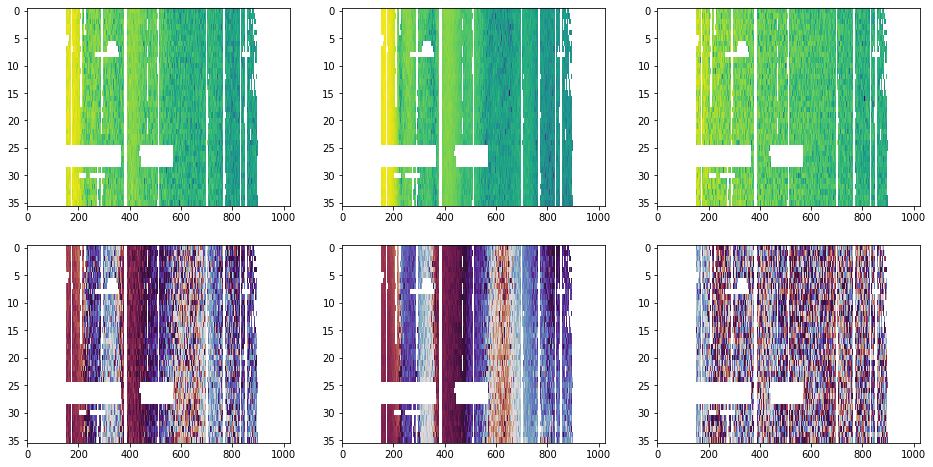

In [69]:
jd_toplot = jds[4]
plot_differences(uvds_hflag[jd_toplot], uvds_avg[jd_toplot], (9,20,'xy'))

In [20]:
bl_data_avg = uvd_avg.get_data(bl_typ)
bl_flags_avg = uvd_avg.get_flags(bl_typ)

divide by zero encountered in log10
divide by zero encountered in true_divide


Text(0.5, 1.0, 'average')

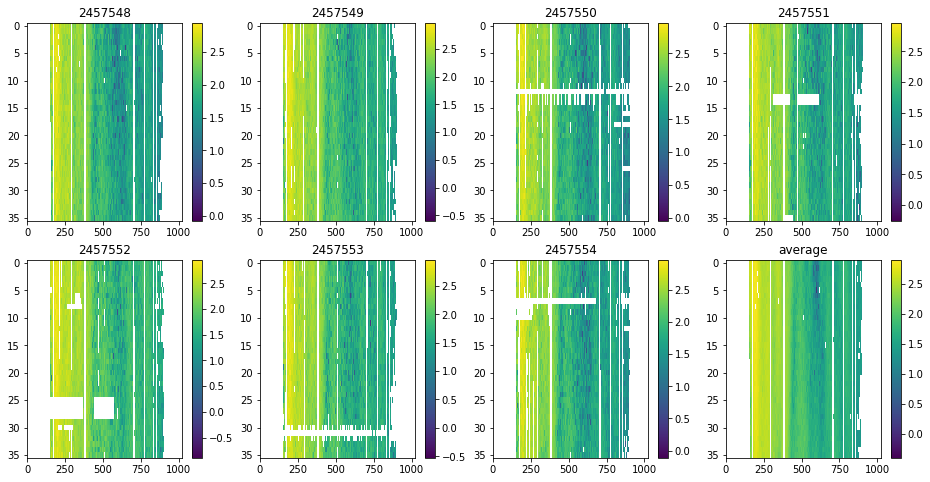

In [22]:
plt.figure(figsize=(16,8))
for i in np.arange(7):
    plt.subplot(2,4,i+1)               
    bl = uvdbl[jds[i]].squeeze()
    
    plt.imshow(np.log10(np.abs(bl))/~uvfs[jds[i]].flag_array.squeeze(), aspect='auto')
    #plt.imshow(np.log10(np.abs(bl)), aspect='auto', vmin=0, vmax=2.5)
    #plt.imshow(np.angle(bl), aspect='auto', cmap='twilight')
    plt.colorbar()
    plt.title(jds[i])
plt.subplot(2,4,8)
plt.imshow(np.log10(np.abs(bl_data_avg.squeeze()))/~bl_flags_avg.squeeze(), aspect='auto')
#plt.imshow(np.log10(np.abs(bl)), aspect='auto', vmin=0, vmax=2.5)
#plt.imshow(np.angle(bl), aspect='auto', cmap='twilight')
plt.colorbar()
plt.title('average')

invalid value encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


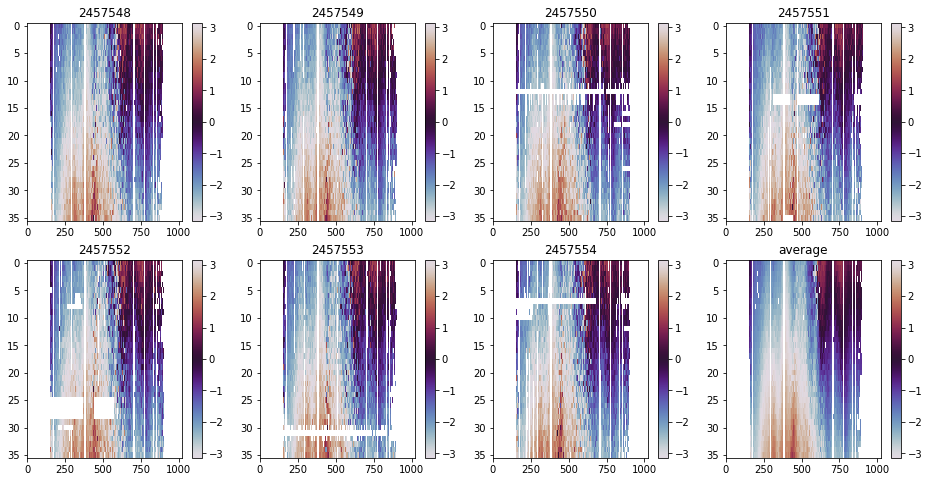

In [25]:
plt.figure(figsize=(16,8))
for i in np.arange(7):
    plt.subplot(2,4,i+1)               
    bl = uvdbl[jds[i]].squeeze()
    
    #plt.imshow(np.log10(np.abs(bl))/~uvfs[jds[i]].flag_array.squeeze(), aspect='auto')
    #plt.imshow(np.log10(np.abs(bl)), aspect='auto', vmin=0, vmax=2.5)
    plt.imshow(np.angle(bl)/~uvfs[jds[i]].flag_array.squeeze(), aspect='auto', cmap='twilight')
    plt.colorbar()
    plt.title(jds[i])
plt.subplot(2,4,8)
plt.imshow(np.log10(np.abs(bl_data_avg.squeeze()))/~bl_flags_avg.squeeze(), aspect='auto')
#plt.imshow(np.log10(np.abs(bl)), aspect='auto', vmin=0, vmax=2.5)
plt.imshow(np.angle(bl_data_avg.squeeze())/~bl_flags_avg.squeeze(), aspect='auto', cmap='twilight')
plt.colorbar()
plt.title('average')
plt.show()

divide by zero encountered in true_divide
divide by zero encountered in log10
divide by zero encountered in true_divide


Text(0.5, 1.0, 'average')

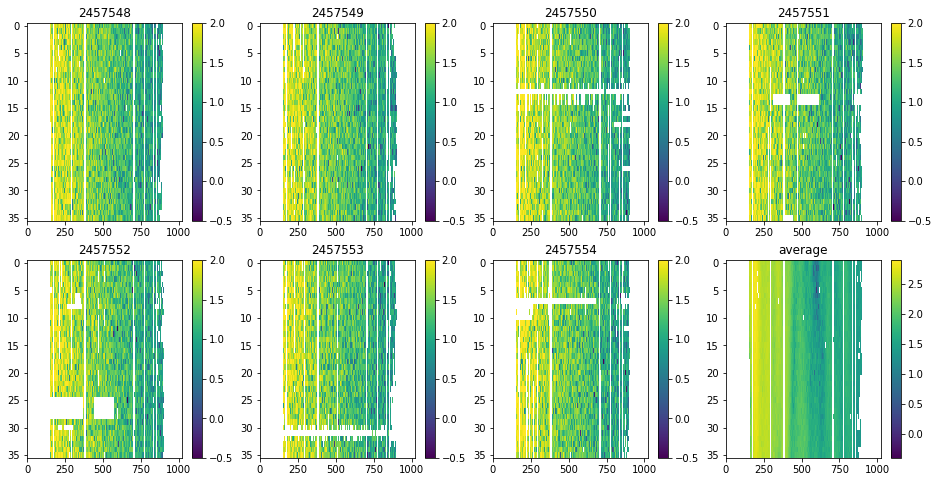

In [27]:
plt.figure(figsize=(16,8))
for i in np.arange(7):
    plt.subplot(2,4,i+1)               
    bl = uvdbl[jds[i]].squeeze()
    
    plt.imshow(np.log10(np.abs(bl-bl_data_avg.squeeze()))/~uvfs[jds[i]].flag_array.squeeze(), aspect='auto',
              vmin=-0.5,vmax=2)
    #plt.imshow(np.log10(np.abs(bl)), aspect='auto', vmin=0, vmax=2.5)
    #plt.imshow(np.angle(bl), aspect='auto', cmap='twilight')
    plt.colorbar()
    plt.title(jds[i])
plt.subplot(2,4,8)
plt.imshow(np.log10(np.abs(bl_data_avg.squeeze()))/~bl_flags_avg.squeeze(), aspect='auto')
#plt.imshow(np.log10(np.abs(bl)), aspect='auto', vmin=0, vmax=2.5)
#plt.imshow(np.angle(bl), aspect='auto', cmap='twilight')
plt.colorbar()
plt.title('average')

invalid value encountered in true_divide
divide by zero encountered in true_divide


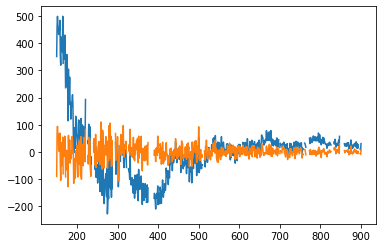

In [30]:
plt.plot(((bl)/~uvfs[jds[i]].flag_array.squeeze())[0,:].real)
plt.plot(((bl-bl_data_avg.squeeze())/~uvfs[jds[i]].flag_array.squeeze())[0,:].real)